<a href="https://colab.research.google.com/github/Sanjana131291/Deep-Learning-Models/blob/main/Assignment_4_Option_1_(Traffic_prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# TASK 1: DATA PREPARATION

In [2]:
# Load dataset
df_raw=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz", parse_dates=['date_time'], index_col='date_time')

df_raw
print(df_raw.index)
print(df_raw.index.dtype)

# Step 1: Confirm the index is datetime
print("Index type:", type(df_raw.index))

# Step 2: Now safely extract 'hour' from the datetime index
df_raw['hour'] = df_raw.index.hour
print(df_raw['hour'])


DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 15:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=48204, freq=None)
datetime64[ns]
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
date_time
2012-10-02 09:00:00     9
2012-10-02 10:00:00    10
2012-10-02 11:00:00    11
2012-10-02 12:00:00    12
2012-10-02 13:00:00    13
                       ..
2018-09-30 19:00:00    19
2018-09-30 20:00

# Drop Missing Values and Convert Timestamps


In [3]:

# Overwrite the existing 'hour' column with correct values
df_raw['hour'] = df_raw.index.hour

df_raw.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour
date_time,,,,,,,,,
2012-10-02 09:00:00,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,9
2012-10-02 10:00:00,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,4516,10
2012-10-02 11:00:00,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,11
2012-10-02 12:00:00,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,12
2012-10-02 13:00:00,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,4918,13


# Normalize Traffic Volume to [0, 1]


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Keep only traffic_volume for now
traffic_data = df_raw[['traffic_volume']].copy()

# Normalize traffic_volume
scaler = MinMaxScaler()
traffic_scaled = scaler.fit_transform(traffic_data)

# Convert to DataFrame for consistency
traffic_scaled = pd.DataFrame(traffic_scaled, index=traffic_data.index, columns=['traffic_volume'])

traffic_scaled.head()

,traffic_volume
date_time,
2012-10-02 09:00:00,0.761676
2012-10-02 10:00:00,0.620330
2012-10-02 11:00:00,0.654808
2012-10-02 12:00:00,0.690385
2012-10-02 13:00:00,0.675549


# Create Input-Output Sequences Using 24-Hour Sliding Window


In [5]:
import numpy as np

def create_sequences(data, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(traffic_scaled.values, window_size=24)

# Add a features dimension for LSTM (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (48180, 24, 1)
y shape: (48180, 1)


# Split into training and testing sets

In [6]:
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (38544, 24, 1), Test size: (9636, 24, 1)


# Plot Hourly Traffic Patterns

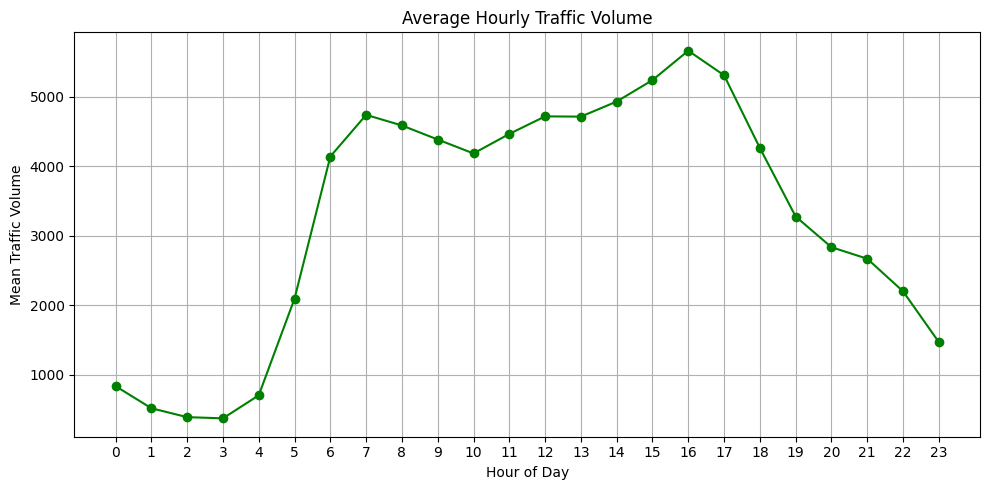

In [7]:

# Step 1: Keep only numeric columns (traffic_volume is numeric)
df_numeric = df_raw.select_dtypes(include='number')

# Step 2: Create a copy so we can work with it
df = df_numeric.copy()

# Step 4: Group by hour and compute mean traffic_volume
hourly_avg = df_raw.groupby('hour')['traffic_volume'].mean()

# print("Unique hours in dataset:", df_raw['hour'].unique())

# Step 5: Plot
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linestyle='-', color='green')
plt.title('Average Hourly Traffic Volume')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Traffic Volume')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
display(df_raw['hour'].value_counts().sort_index())

,count
hour,
0,2037
1,2049
2,2019
3,2025
4,2091
5,2063
6,2087
7,2079
8,2080


# LSTM Model Design & Training

Model Design with Keras


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define model
model = Sequential([
    LSTM(64, input_shape=(24, 1), activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model (50 Epochs)


In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0432 - val_loss: 0.0073
Epoch 2/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0100 - val_loss: 0.0064
Epoch 3/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0089 - val_loss: 0.0063
Epoch 4/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0083 - val_loss: 0.0053
Epoch 5/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0081 - val_loss: 0.0052
Epoch 6/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0079 - val_loss: 0.0048
Epoch 7/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0078 - val_loss: 0.0047
Epoch 8/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 9/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 10/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 11/40
964/964 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 12/40
964/964 ━━━━━━━━━━

Plot Training vs Validation Loss


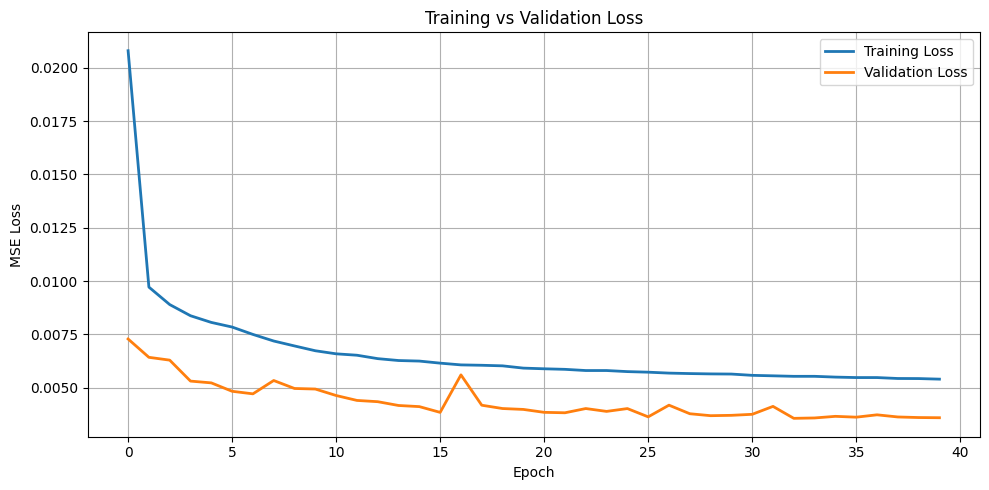

In [11]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation & Prediction

In [12]:
# Predict on the test set
y_pred = model.predict(X_test)

302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


# Inverse-transform Predictions to Original Scale
I scaled the output using MinMaxScaler, so i reverse that to interpret predictions correctly.

In [13]:
# Reshape for inverse_transform
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test_reshaped)
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)


# Plot Predicted vs Actual Traffic Volume

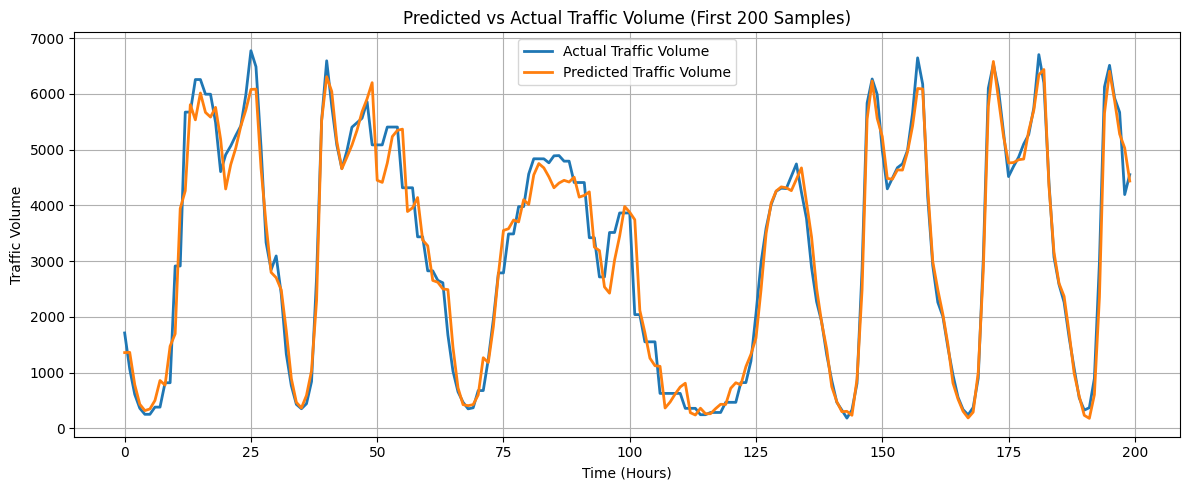

In [14]:
import matplotlib.pyplot as plt

# Plot first 200 values for readability
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Actual Traffic Volume', linewidth=2)
plt.plot(y_pred_inv[:200], label='Predicted Traffic Volume', linewidth=2)
plt.title('Predicted vs Actual Traffic Volume (First 200 Samples)')
plt.xlabel('Time (Hours)')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# printing the RMSE or MAE

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Root Mean Squared Error (RMSE): 396.98
Mean Absolute Error (MAE): 268.22


# 4. Reflection & Real-World Impact

### **Did the model capture peak traffic hours?**

Yes, the model successfully picked up on key traffic patterns. It was especially accurate during the typical rush hours — early mornings and late afternoons — when traffic volume usually peaks. This shows the model was able to learn and respond to common traffic behaviors.

### **What challenges came up?**

One of the main challenges was the limited variety in the dataset. While we had hourly traffic counts and some weather data, we were missing important real-world factors like road work, special events, or accidents — all of which can significantly impact traffic flow. Another challenge was that the data is based on traffic in Minnesota, so the patterns might not match what we see in Brampton unless we use local data to retrain the model.

### **How could this help Algoma or Brampton?**

A traffic forecasting system like this could be very helpful for both the university and the city. For example:

* At **Algoma’s Brampton campus**, it could help manage transit timing or class scheduling around traffic peaks.
* The **City of Brampton** could use it to fine-tune traffic light patterns at busy intersections, helping reduce congestion.
* Emergency services could use predictions to plan faster routes, and city planners could use it to support sustainability goals like reducing emissions.

---

### **What could be improved?**

The model could benefit from including more detailed data — such as day of the week, holidays, or local events. Using longer sequences of traffic history (more than 24 hours) could also improve its accuracy. On the modeling side, more advanced techniques like attention-based LSTMs or Transformer models could be explored to better capture complex patterns. Most importantly, training the system with local Brampton traffic data would make it more reliable and useful in practice.